In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, Attention
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
import librosa
from keras.utils.vis_utils import plot_model

# Data Generator

In [2]:
data = pd.read_csv("data_metadata.csv")
train_data = pd.read_csv("train_data.csv")
val_data = pd.read_csv("val_data.csv")

In [3]:
class AudioDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, csv_file, batch_size=32, num_classes=11, sample_rate=22050, duration=10.0, shuffle=True, n_mels=128):
        self.csv_file = csv_file
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.sample_rate = sample_rate
        self.duration = duration
        self.shuffle = shuffle
        self.n_mels  = n_mels
        
        # Read the CSV file
        self.data = pd.read_csv(csv_file)
        
        # Get the unique class labels
        self.classes = sorted(self.data['class_label'].unique())
        
        # Create a dictionary to map class labels to integers
        self.class_to_int = dict(zip(self.classes, range(len(self.classes))))
        
        # Shuffle the data if requested
        if self.shuffle:
            self.data = self.data.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        # Return the number of batches
        return int(np.ceil(len(self.data) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        # Get the batch of file paths and labels
        batch_data = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_data = batch_data.reset_index()
        # Initialize the arrays for the audio data and labels
        batch_x = np.zeros((len(batch_data), 431, self.n_mels,1))
        batch_y = np.zeros((len(batch_data), self.num_classes))
        
        # Load the audio files and their corresponding labels
        for i, row in batch_data.iterrows():
            file_path = row['file_path']
            class_label = row['class_label']
            
            # Load the audio file
            signal, sr = librosa.load(file_path, sr=self.sample_rate, mono=True)
            
            # Pad or truncate the signal to the desired length
            signal = librosa.util.fix_length(signal, size=self.sample_rate * self.duration)
            
            # Convert the audio file to spectrogram
            S = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=self.n_mels)
            S_dB = np.array(librosa.power_to_db(S, ref=np.max))
            S_dB = np.rot90(S_dB, k=3)
            S_dB = S_dB.reshape(S_dB.shape[0],S_dB.shape[1],1)
            
            # Save the audio data and label to the batch arrays
            batch_x[i, :] = S_dB
            batch_y[i, :] = to_categorical(self.class_to_int[class_label], num_classes=self.num_classes)
            

        return batch_x, batch_y

In [4]:
train_generator = AudioDataGenerator('train_data.csv', batch_size=32, num_classes=11, sample_rate=22050, duration=10, shuffle=True, n_mels=128)

In [5]:
val_generator = AudioDataGenerator('val_data.csv', batch_size=32, num_classes=11, sample_rate=22050, duration=10, shuffle=True, n_mels=128)

# Model creation

In [6]:
# Defining Metrics

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D, Reshape, Multiply, Lambda
from keras.models import Model
import keras.backend as K

In [8]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

In [16]:
from tensorflow.keras import layers

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical")
])

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Multiply, Reshape, Permute, Lambda

# Define the input shape of the spectrogram (time_steps, frequency_bins, channels)
input_shape = (431, 128, 1)

# Define the input tensor
inputs = Input(shape=input_shape)

# Define the CNN layers
x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Reshape the output of the CNN layers to be a sequence of feature vectors
x = Reshape((-1, 128))(x)

# Define the LSTM layers
x = LSTM(128, return_sequences=True)(x)
x = LSTM(128, return_sequences=True)(x)

# Define the attention mechanism
att = Dense(1, activation='tanh')(x)
att = Flatten()(att)
att = Dense(128, activation='softmax')(att)
att = Lambda(lambda x: K.expand_dims(x))(att)
att = Permute((2, 1))(att)
x = Attention()([x, att])
x = Lambda(lambda x: K.sum(x, axis=1))(x)

# Define the classification layers
x = Dense(64, activation='relu')(x)
predictions = Dense(11, activation='softmax')(x)

# Define the model
model = Model(inputs=inputs, outputs=predictions)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])


In [28]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 431, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 431, 128, 32  320         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 215, 64, 32)  0          ['conv2d_10[0][0]']              
                                                                                            

In [30]:
history = model.fit(train_generator,batch_size=32,epochs=16,verbose=1)

Epoch 1/16
447/447 [==============================] - 384s 858ms/step - loss: 2.2855 - accuracy: 0.2871 - f1_m: 0.1027 - precision_m: 0.1787 - recall_m: 0.0805
Epoch 2/16
447/447 [==============================] - 378s 845ms/step - loss: 1.5291 - accuracy: 0.4397 - f1_m: 0.2958 - precision_m: 0.5179 - recall_m: 0.2255
Epoch 3/16
447/447 [==============================] - 374s 836ms/step - loss: 1.4613 - accuracy: 0.4554 - f1_m: 0.3508 - precision_m: 0.5741 - recall_m: 0.2648
Epoch 4/16
447/447 [==============================] - 377s 843ms/step - loss: 0.9364 - accuracy: 0.6495 - f1_m: 0.6151 - precision_m: 0.7441 - recall_m: 0.5305
Epoch 5/16
447/447 [==============================] - 375s 838ms/step - loss: 0.6525 - accuracy: 0.7542 - f1_m: 0.7471 - precision_m: 0.8078 - recall_m: 0.6975
Epoch 6/16
447/447 [==============================] - 375s 839ms/step - loss: 0.4458 - accuracy: 0.8349 - f1_m: 0.8321 - precision_m: 0.8654 - recall_m: 0.8029
Epoch 7/16
447/447 [====================

In [ ]:
model.save("CNN_LSTM.h5")

In [ ]:
model =tf.keras.models.load_model("CNN_LSTM.h5",custom_objects={"f1_m":f1_m,'precision_m':precision_m, 'recall_m':recall_m})

In [31]:
loss, accuracy, f1_score, precision, recall = model.evaluate(val_generator)

112/112 [==============================] - 102s 877ms/step - loss: 0.3675 - accuracy: 0.9038 - f1_m: 0.9051 - precision_m: 0.9091 - recall_m: 0.9012


In [32]:
print('Validation accuracy:', accuracy)
print('Validation loss:', loss)
print('Validation f1:', f1_score)
print('Validation precision:', precision)
print('Validation recall:', recall)


Validation accuracy: 0.9038031101226807
Validation loss: 0.36747875809669495
Validation f1: 0.9051002860069275
Validation precision: 0.9091225266456604
Validation recall: 0.9012276530265808


In [33]:
import pickle

In [34]:
pickle_out = open("CNN_LSTM_history.pickle","wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

In [35]:
pickle_in = open('CNN_LSTM_history.pickle', "rb")
history = pickle.load(pickle_in)

In [36]:
history = history.history

AttributeError: 'dict' object has no attribute 'history'

In [37]:
import matplotlib.pyplot as plt

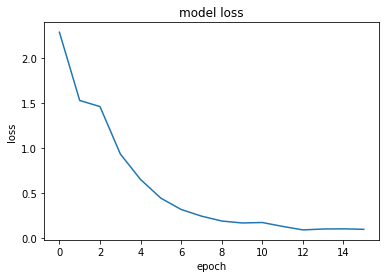

In [38]:
plt.plot(history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.close()

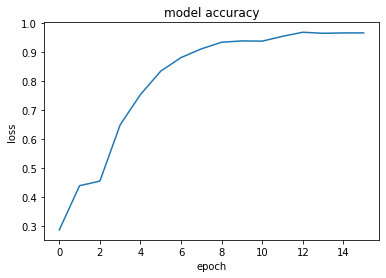

In [39]:
plt.plot(history['accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.close()

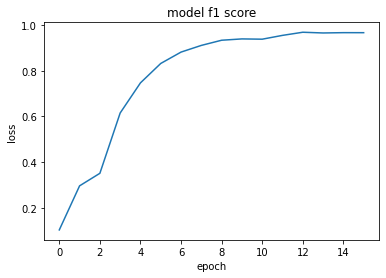

In [40]:
plt.plot(history['f1_m'])
plt.title('model f1 score')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.close()

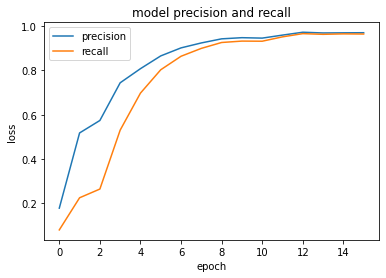

In [41]:
plt.plot(history['precision_m'])
plt.plot(history['recall_m'])
plt.title('model precision and recall')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['precision','recall'])
plt.show()
plt.close()